In [362]:
import numpy as np

def angle(v1, v2):
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

class PointCloud:
    def __init__(self):
        self.ncols = 0
        self.nrows = 0
        self.pos = None
        self.axis = None
        self.transform = None
        self.points = None
        self.labels = None
        self.normals = None
    
    def read_from_file(self, fn):
        with open(fn, 'r') as f:
            self.nrows = int(f.readline().strip())
            self.ncols = int(f.readline().strip())

            self.pos = list(map(int, f.readline().split()))
            self.axis = [
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
            ]
            self.transform = [
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
            ]
            
            self.points = np.zeros(shape=(self.nrows, self.ncols, 3))
            
            for r in range(self.nrows):
                for c in range(self.ncols):
                    self.points[r][c] += list(map(float, f.readline().split()))[:3]
                    
        return
                    
    def segment(self):
        theta_thresh = 0.3
        self.labels = np.zeros((self.nrows, self.ncols))
        self.normals = np.zeros((self.nrows, self.ncols))
        
        tri_normals = np.zeros((self.nrows-1, 2*(self.ncols-1), 3))
        
        for r in range(self.nrows-1):
            for c in range(self.ncols-1):
                p1 = self.points[r][c]
                p2 = self.points[r][c+1]
                p3 = self.points[r+1][c]
                p4 = self.points[r+1][c+1]

                n1 = np.cross(p4-p3, p1-p3)
                if np.any(p1) and np.any(p3) and np.any(p4):
                    tri_normals[r][2*c] = n1 / np.linalg.norm(n1)

                n2 = np.cross(p1-p2, p4-p2)
                if np.any(p1) and np.any(p2) and np.any(p4):
                    tri_normals[r][2*c+1] = n2 / np.linalg.norm(n2)
        
        tri_labels = np.zeros((tri_normals.shape[0], tri_normals.shape[1]))
        
        label = 1
        equivalence_table = dict()
        for r in range(self.nrows-1):
            for c in range(self.ncols-1):
                if np.any(tri_normals[r][2*c]):
                    if c-1 >= 0 and np.any(tri_normals[r][2*c-1]):
                        if angle(tri_normals[r][2*c-1], tri_normals[r][2*c]) < theta_thresh:
                            tri_labels[r][2*c] = tri_labels[r][2*c-1]
                        else:
                            tri_labels[r][2*c] = label
                            label += 1
                    else:
                        tri_labels[r][2*c] = label
                        label += 1
                
                if np.any(tri_normals[r][2*c+1]):
                    if r-1 >= 0 and np.any(tri_normals[r-1][2*c]):
                        if angle(tri_normals[r-1][2*c], tri_normals[r][2*c+1]) < theta_thresh:
                            tri_labels[r][2*c+1] = tri_labels[r-1][2*c]
                        else:
                            tri_labels[r][2*c+1] = label
                            label += 1
                    else:
                        tri_labels[r][2*c+1] = label
                        label += 1
                    
                if np.any(tri_normals[r][2*c]) and np.any(tri_normals[r][2*c+1]):
                    if angle(tri_normals[r][2*c], tri_normals[r][2*c+1]) < theta_thresh:
                        equivalent_labels = list([tri_labels[r][2*c], tri_labels[r][2*c+1]])
                        
                        if tri_labels[r][2*c] in equivalence_table:
                            equivalent_labels.append(equivalence_table[tri_labels[r][2*c]])
                            
                        if tri_labels[r][2*c+1] in equivalence_table:
                            equivalent_labels.append(equivalence_table[tri_labels[r][2*c+1]])
                            
                        target = min(equivalent_labels)
                        
                        for el in equivalent_labels:
                            if el != target:
                                equivalence_table[el] = target
            
        final_mapping = dict()
        label_id = 1
        
        count = dict()
        for i in range(tri_labels.shape[0]):
            for j in range(tri_labels.shape[1]):
                if tri_labels[i][j] == 0:
                    continue
#                 if tri_labels[i][j] not in equivalence_table:
#                     tri_labels[i][j] = 0
#                     continue
                    
    
                while tri_labels[i][j] in equivalence_table:
                    tri_labels[i][j] = equivalence_table[tri_labels[i][j]]
                    
                if tri_labels[i][j] not in final_mapping:
                    final_mapping[tri_labels[i][j]] = label_id
                    label_id += 1
                    
                tri_labels[i][j] = final_mapping[tri_labels[i][j]]
                
                if tri_labels[i][j] not in count:
                    count[tri_labels[i][j]] = 0
                    
                count[tri_labels[i][j]] += 1
        
        print(count)
        return tri_labels, label_id-1
                
    def dims(self):
        return (self.nrows, self.ncols)


ptcld_dir = './DATA/small_example.ptx'

pc = PointCloud()
pc.read_from_file(ptcld_dir)

nrows, ncols = pc.dims()

In [363]:
pc2 = PointCloud()
pc2.read_from_file(ptcld_dir)
labels, nlabel = pc2.segment()

{1.0: 5412, 2.0: 5307, 3.0: 1, 4.0: 1, 5.0: 3, 6.0: 1, 7.0: 5, 8.0: 9, 9.0: 1, 10.0: 1, 11.0: 1, 12.0: 2, 13.0: 8, 14.0: 1, 15.0: 1, 16.0: 1, 17.0: 6, 18.0: 1, 19.0: 1, 20.0: 1, 21.0: 2, 22.0: 5, 23.0: 1, 24.0: 3, 25.0: 2, 26.0: 1, 27.0: 2, 28.0: 3, 29.0: 7, 30.0: 1, 31.0: 2, 32.0: 7, 33.0: 1, 34.0: 2, 35.0: 1, 36.0: 7, 37.0: 1, 38.0: 2, 39.0: 1, 40.0: 1, 41.0: 2, 42.0: 2, 43.0: 1, 44.0: 1, 45.0: 1, 46.0: 2, 47.0: 1, 48.0: 1, 49.0: 4, 50.0: 1, 51.0: 1, 52.0: 15611, 53.0: 4, 54.0: 2, 55.0: 1, 56.0: 1, 57.0: 2, 58.0: 1, 59.0: 1, 60.0: 4, 61.0: 2, 62.0: 1, 63.0: 1, 64.0: 2, 65.0: 1, 66.0: 1, 67.0: 1, 68.0: 1, 69.0: 4, 70.0: 2, 71.0: 1, 72.0: 1, 73.0: 1, 74.0: 4, 75.0: 2, 76.0: 1, 77.0: 1, 78.0: 1, 79.0: 2, 80.0: 1, 81.0: 1, 82.0: 2, 83.0: 2, 84.0: 4, 85.0: 2, 86.0: 1, 87.0: 1, 88.0: 1, 89.0: 1, 90.0: 1, 91.0: 2, 92.0: 906, 93.0: 2, 94.0: 2, 95.0: 2, 96.0: 1, 97.0: 1, 98.0: 2, 99.0: 4, 100.0: 2, 101.0: 1, 102.0: 1, 103.0: 2, 104.0: 1, 105.0: 4, 106.0: 2, 107.0: 1, 108.0: 1, 109.0: 2, 110.0

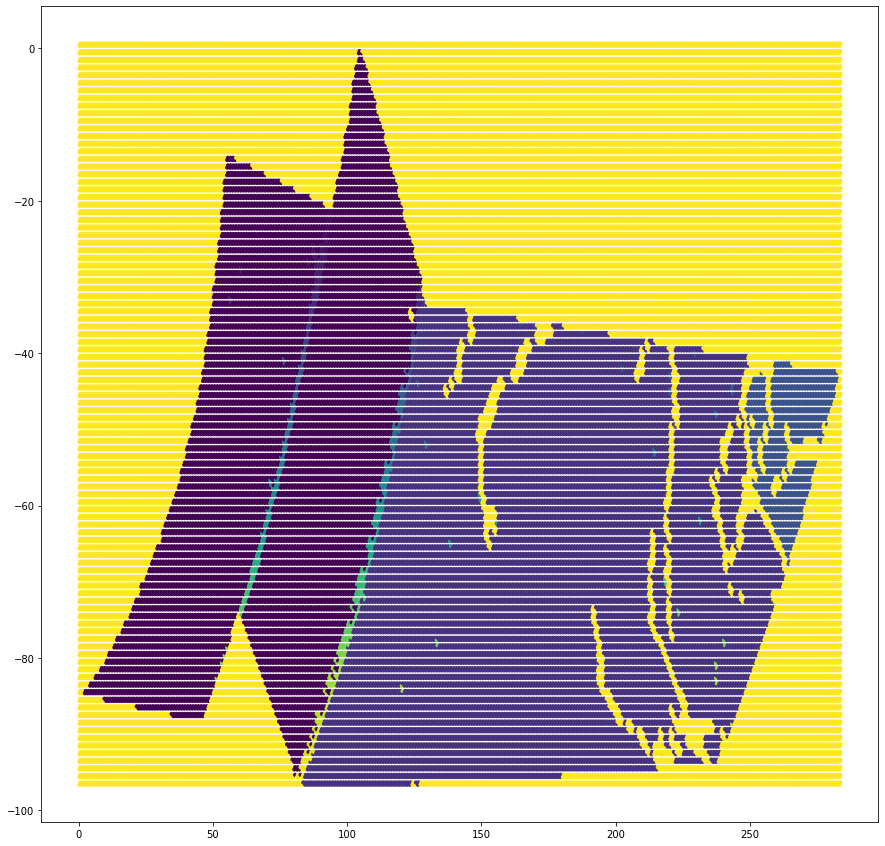

In [364]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

grid = list()
for r in range(nrows-1):
    for c in range(ncols-1):
        grid.append((-r+0.35, c+0.35))
        grid.append((-r+0.65, c+0.65))
        
x, y = zip(*grid)
c = np.abs(labels.reshape(((nrows-1)*((ncols-1)*2)))) / float(nlabel)
c[c == 0] = 1.0

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(y, x, c=c, s=10.0)

plt.show()

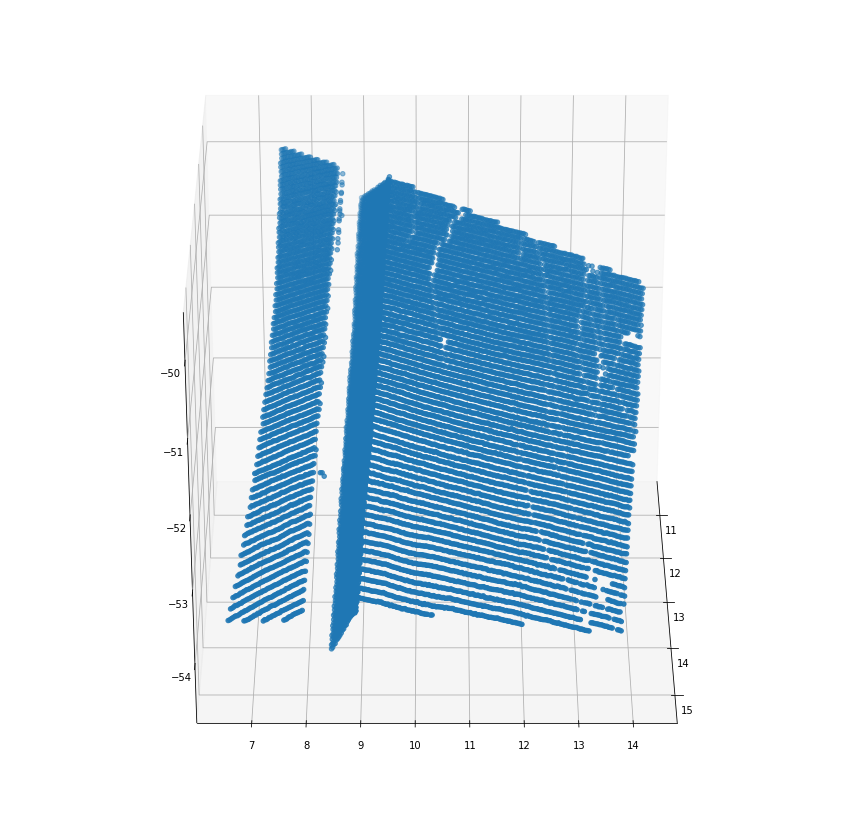

In [150]:
from IPython.display import clear_output

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ax.set_aspect('equal')

valid_points = list()
for r in range(nrows):
    for c in range(ncols):
        if np.linalg.norm(pc.points[r][c]) > 0:
            valid_points.append(pc.points[r][c])
    
x, y, z = zip(*valid_points)

for angle in range(0, 360, 360):
    if 'ax' in globals():
        ax.remove()
        
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    ax.view_init(30, angle)
    
    clear_output(wait=True)
    plt.draw()
    plt.pause(.0001)

In [159]:
tri_normals = np.zeros((nrows-1, (ncols-1)*2, 3))
tri_normals.shape

for r in range(nrows-1):
    for c in range(ncols-1):
        p1 = pc.points[r][c]
        p2 = pc.points[r][c+1]
        p3 = pc.points[r+1][c]
        p4 = pc.points[r+1][c+1]
        
        if np.any(p1) and np.any(p3) and np.any(p4):
            n1 = np.cross(p4-p3, p1-p3)
            tri_normals[r][2*c] = n1 / np.linalg.norm(n1)

        if np.any(p1) and np.any(p2) and np.any(p4):
            n2 = np.cross(p1-p2, p4-p2)
            tri_normals[r][2*c+1] = n2 / np.linalg.norm(n2)

(98, 568, 3)

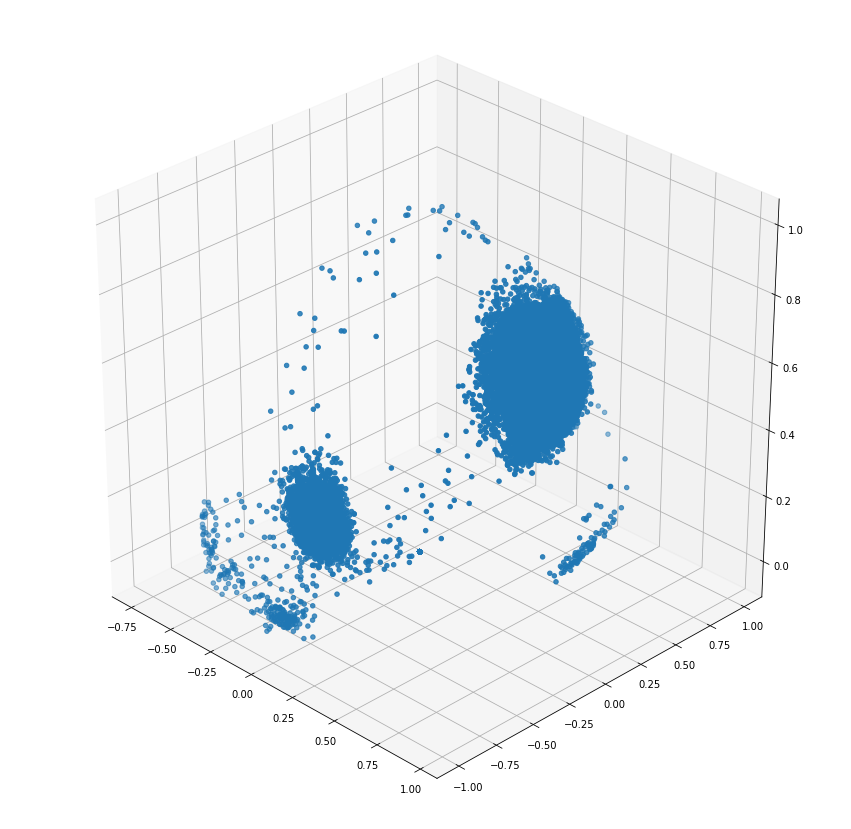

In [111]:
norm_list = tri_normals.reshape((tri_normals.shape[0]*tri_normals.shape[1], tri_normals.shape[2]))
x, y, z = zip(*norm_list)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.view_init(30, 315)

plt.show()

In [112]:
pt_normals = np.zeros((nrows, ncols, 3))
for r in range(nrows):
    for c in range(ncols):
        r_1 = r - 1
        c_1 = c - 1
        
        tris = list()
        if r_1 >= 0 and c_1 >= 0:
            tris.append((r_1, 2*c_1))
            tris.append((r_1, 2*c_1+1))

        if r < nrows - 1 and c < ncols - 1:
            tris.append((r, 2*c))
            tris.append((r, 2*c+1))
            
        if c_1 >= 0 and r < nrows - 1:
            tris.append((r, 2*c_1+1))
            
        if r_1 >= 0 and c < ncols - 1:
            tris.append((r_1, 2*c))
            
        count = 0
        for tr, tc in tris:
            if np.any(tri_normals[tr][tc]):
                pt_normals[r][c] += tri_normals[tr][tc]
                count += 1
                
        if count > 0:
            pt_normals[r][c] /= count

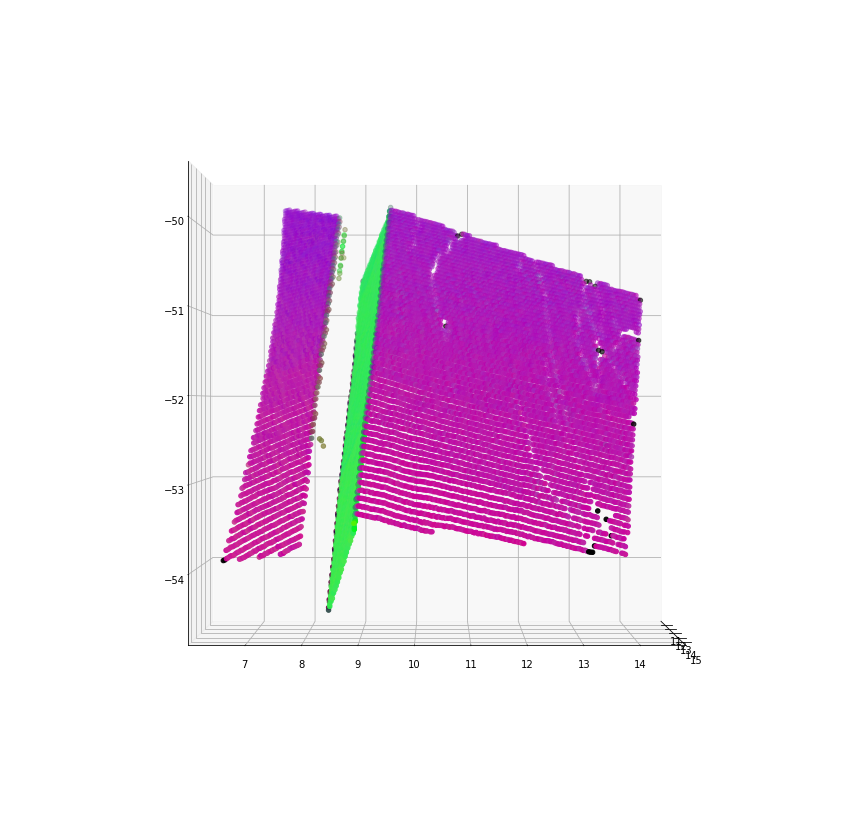

In [158]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

valid_points = list()
valid_normals = list()
for r in range(nrows):
    for c in range(ncols):
        if np.linalg.norm(pc.points[r][c]) > 0:
            valid_points.append(pc.points[r][c])
            valid_normals.append(pt_normals[r][c])
    
x, y, z = zip(*valid_points)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=np.abs(valid_normals))
ax.view_init(0, 0)


plt.show()

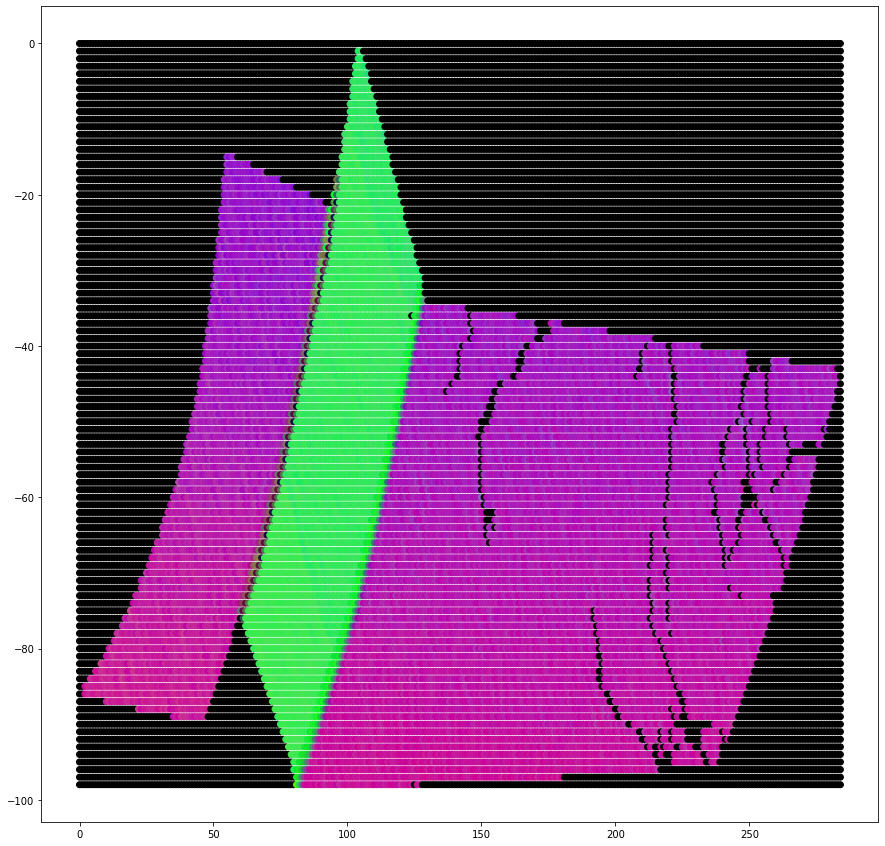

In [123]:
import matplotlib.pyplot as plt

grid = [(c, -r) for r in range(nrows) for c in range(ncols)]
x, y = zip(*grid)
c = np.abs(pt_normals.reshape((nrows*ncols, 3)))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=c)

plt.show()

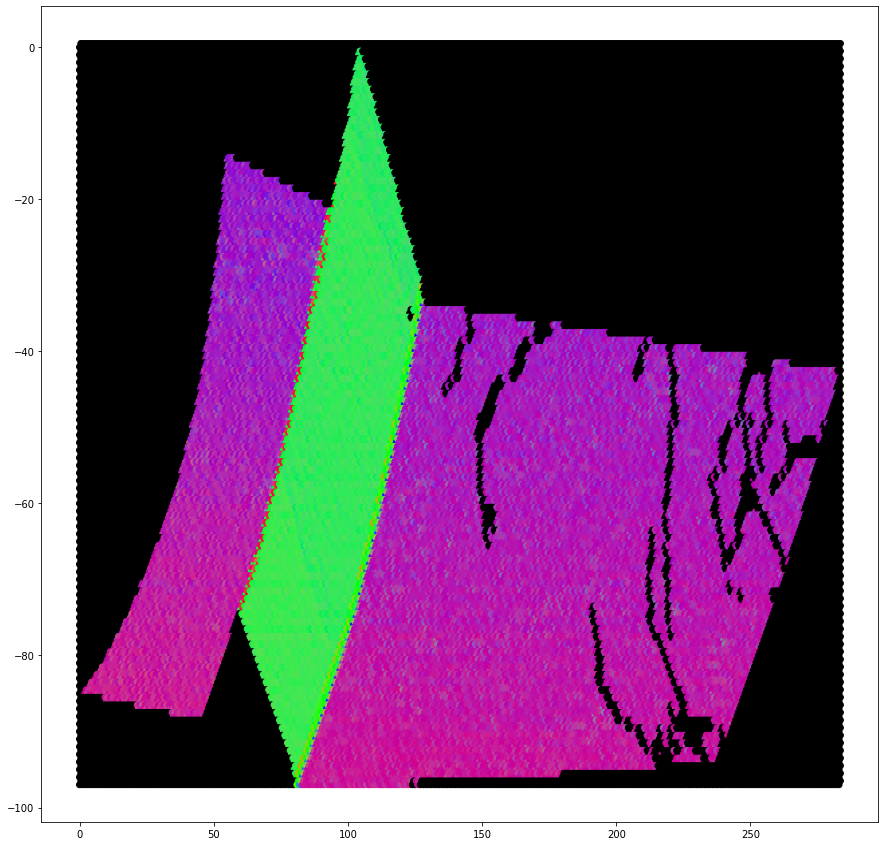

In [126]:
grid = list()
for r in range(nrows-1):
    for c in range(ncols-1):
        grid.append((-r, c))
        grid.append((-r+0.5, c+0.5))
        
y, x = zip(*grid)
c = np.abs(tri_normals.reshape(((nrows-1)*((ncols-1)*2), 3)))

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=c)

plt.show()

In [100]:
np.array([
    [2,3,4],
    [3,4,5]
]).reshape((6))

array([2, 3, 4, 3, 4, 5])